# Linear Regression Project: Predicting Yearly Ecommerce Spend

##### In this project, I work with a dataset that contains information about customers of an e-commerce clothing business. The company wants to determine whether to focus on improving the website or the mobile app. Our goal is to build a linear regression model that predicts Yearly Amount Spent based on customer behavior, and analyze which platform correlates more strongly with higher spending.


## 1) Import Libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pylab
import scipy.stats as stats

## 2) Load and Examine the Dataset

In [6]:
df = pd.read_csv("../data/ecommerce_data.csv")
df.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


#### With .info(), we see that 'Email', 'Address', and 'Avatar' are non-numeric and/or high-cardinality columns that are not useful for regression. Their predictive value is not useful in our case.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Email                 500 non-null    object 
 1   Address               500 non-null    object 
 2   Avatar                500 non-null    object 
 3   Avg. Session Length   500 non-null    float64
 4   Time on App           500 non-null    float64
 5   Time on Website       500 non-null    float64
 6   Length of Membership  500 non-null    float64
 7   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5), object(3)
memory usage: 31.4+ KB


#### .describe() tells us there are no obvious outliers, no missing data points, and that all numerical features are on similar scales (except Length of Membership, which ranges from 0.27 to 6.92 years)

In [8]:
df.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,33.053194,12.052488,37.060445,3.533462,499.314038
std,0.992563,0.994216,1.010489,0.999278,79.314782
min,29.532429,8.508152,33.913847,0.269901,256.670582
25%,32.341822,11.388153,36.349257,2.930450,445.038277
50%,33.082008,11.983231,37.069367,3.533975,498.887875
75%,33.711985,12.753850,37.716432,4.126502,549.313828
max,36.139662,15.126994,40.005182,6.922689,765.518462


## 3) Exploratory Data Analysis (EDA)

#### sns.jointplot() displays both a scatterplot and histogram. The scatterplot reveals no clear linear correlation between Time on Website and Yearly Amount Spent. The points are randomly dispersed in a cloud-like pattern rather than along a line. This suggests that time spent on the website will not be a strong predictor of yearly customer spending.

Text(0.5, 1.02, 'Time on Website vs Yearly Spend')

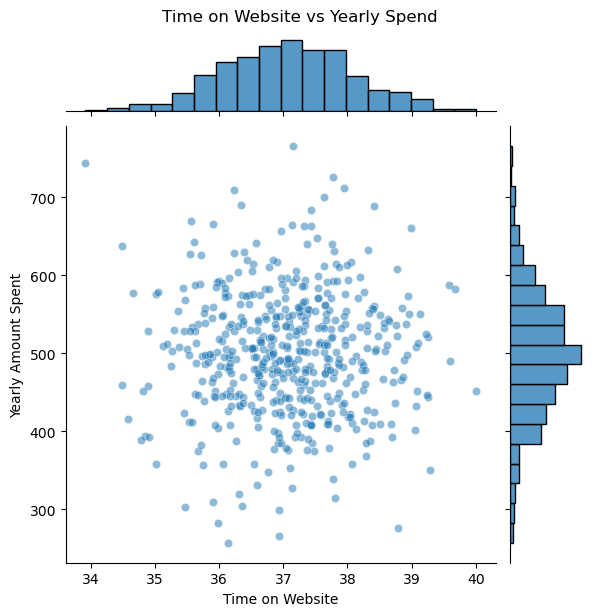

In [9]:
# Time on Website vs. Yearly Amount Spent
sns.jointplot(x='Time on Website', y='Yearly Amount Spent', data=df, alpha=0.5)
plt.suptitle("Time on Website vs Yearly Spend", y=1.02)

#### The scatterplot between Time on App and Yearly Amount Spent shows a visible positive correlation. Unlike the Time on Website plot, this distribution forms a tighter linear pattern, indicating that customers who spend more time on the app tend to spend more money annually. This suggests that the mobile app may be a stronger driver of revenue and could be a valuable area for investment or optimization.

Text(0.5, 1.02, 'Time on App vs Yearly Spend')

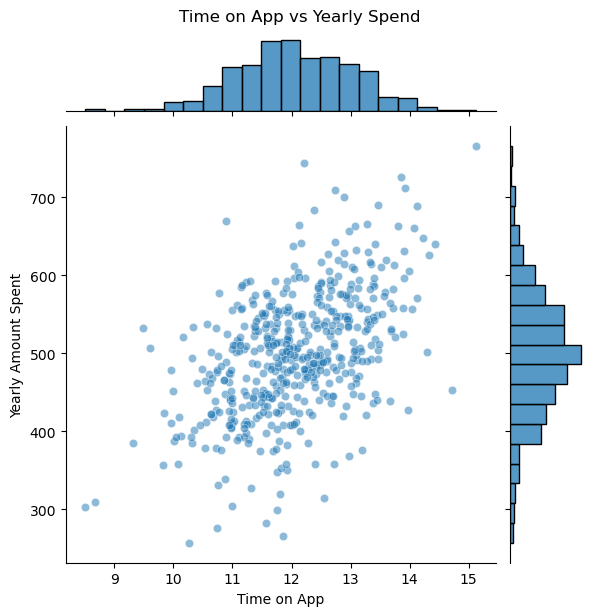

In [24]:
# Time on App vs. Yearly Amount Spent
sns.jointplot(x='Time on App', y='Yearly Amount Spent', data=df, alpha=0.5)
plt.suptitle("Time on App vs Yearly Spend", y=1.02)

#### sns.pairplot() displays scatterplots and histograms. The scatterplots allow us to compare how each variable interacts with one another. This visualization is helpful for identifying multicollinearity amongst input variables—multicollinearity can skew linear regression results, but here we are safe. We also see which variables are most predictive of our label, 'Yearly Amount Spent'. For example, 'Time on App,' and 'Length of Membership' show strong positive relationships with the target variable compared to 'Time on Website.' Lastly, the histograms show us the distribution of our variables. Along the diagonal, the histograms are normally distributed, which is good.


Text(0.5, 1.02, 'Pairplot of All Numerical Features')

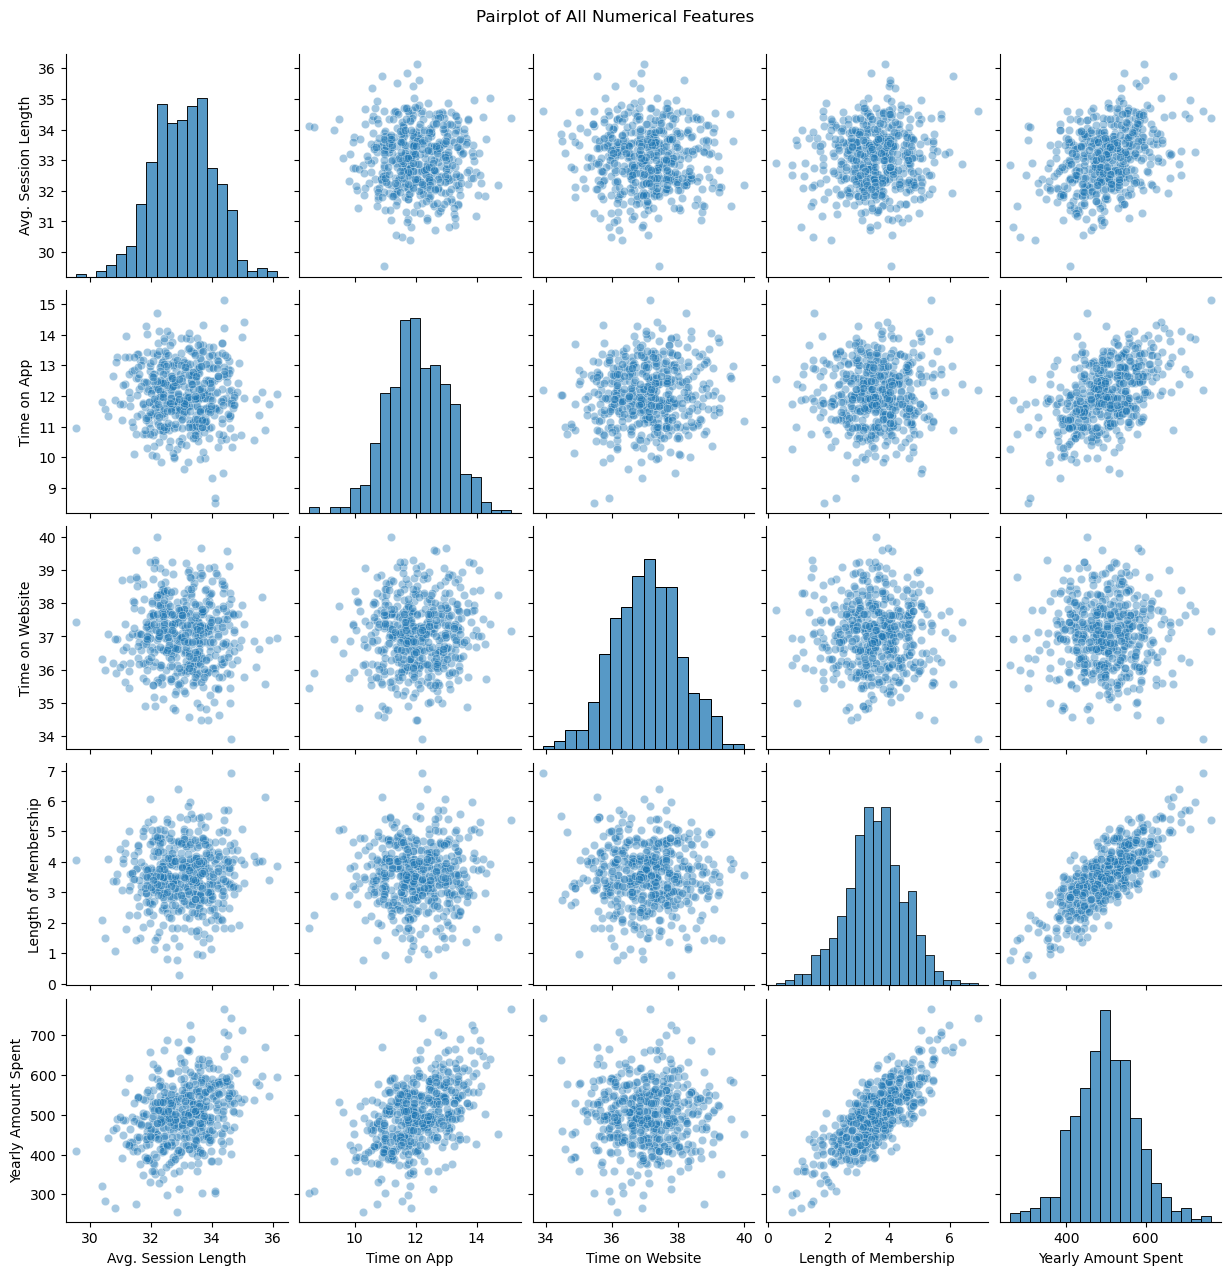

In [12]:
# Pairplot to inspect all relationships
sns.pairplot(df, kind='scatter', plot_kws={'alpha': 0.4})
plt.suptitle("Pairplot of All Numerical Features", y=1.02)

#### The pairplot above revealed that 'Length of Membership' is the most predictive feature in the dataset. sns.lmplot() visualizes the linear relationship between 'Length of Membership' and 'Yearly Money Spent', which confirms our logic that as customers stay with the service longer, their yearly spending tends to increase.

Text(0.5, 1.0, 'Linear Relationship: Membership Length vs Spending')

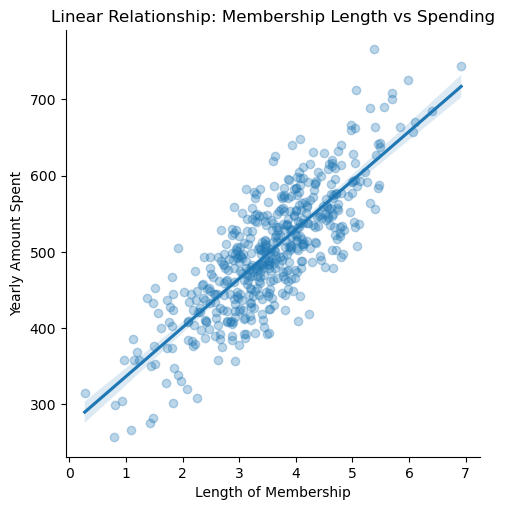

In [13]:
# Visualize the strongest linear relationship in the dataset to validate model assumptions
sns.lmplot(x='Length of Membership', y='Yearly Amount Spent', data=df, scatter_kws={'alpha': 0.3})
plt.title("Linear Relationship: Membership Length vs Spending")

## 4) Feature Selection and Data Splitting

#### Define our features (X), and our target (y). Non-numeric and high-cardinality features were excluded because they do not help predictability.

In [16]:
X = df[['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']]
y = df['Yearly Amount Spent']

#### Split model into training and testing sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 5) Train the Linear Regression Model

In [18]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### The coefficients quantify the impact each feature has on our label. They allow us to interpret how much each variable contributes to the model's output. For example, a high positive coefficient for 'Length of Membership' suggests that increasing app usage is strongly associated with higher spending.

In [19]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients

,Coefficient
Avg. Session Length,25.724256
Time on App,38.597135
Time on Website,0.459148
Length of Membership,61.674732


## 6) Model Predictions and Evaluation

#### Make predictions on the test set

In [21]:
predictions = model.predict(X_test)

#### The scatterplot is a visualization that compares the predicted values from our model (x-axis) to the actual values from our test set (y-axis). Ideally, if our model were perfectly accurate, every point would lie exactly on the 45-degree diagonal line. But because the points fall very close to that line, our model is doing a good job of estimating yearly customer spending. There are no extreme outliers or wild dispersions.

Text(0.5, 1.0, 'Evaluation of Linear Regression Model')

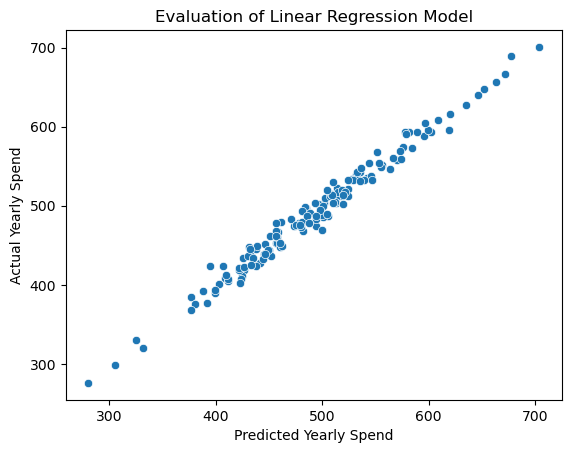

In [23]:
# Scatter plot of predictions vs true values
sns.scatterplot(x=predictions, y=y_test)
plt.xlabel('Predicted Yearly Spend')
plt.ylabel('Actual Yearly Spend')
plt.title('Evaluation of Linear Regression Model')

#### We calculate three regression error metrics to evaluate model performance: MAE, MSE, and RMSE. Our model’s predictions deviate from the actual values by an average of about $8.43 (MAE), with a typical error magnitude around $10.19 (RMSE). These relatively low values indicate strong predictive accuracy, considering the target variable ranges between $250–$750.

In [26]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 8.42609164143212
Mean Squared Error: 103.91554136503332
Root Mean Squared Error: 10.193897260863155


## 7) Residual Analysis

#### Residuals tell us how far off the model was for each prediction. A residual close to 0 means the prediction was highly accurate for that observation.

In [28]:
# Compute residuals
residuals = y_test - predictions
residuals

361    -2.636795
73     -7.800375
374    -8.463174
155     1.953775
104    -0.051825
         ...    
266    10.327176
23     15.027984
222   -16.778237
261    -6.021734
426    -4.371832
Name: Yearly Amount Spent, Length: 150, dtype: float64

#### We plot the residuals to check whether they follow a roughly normal distribution centered around zero. We look for a bell-shaped curve around 0.

Text(0.5, 1.0, 'Distribution of Residuals')

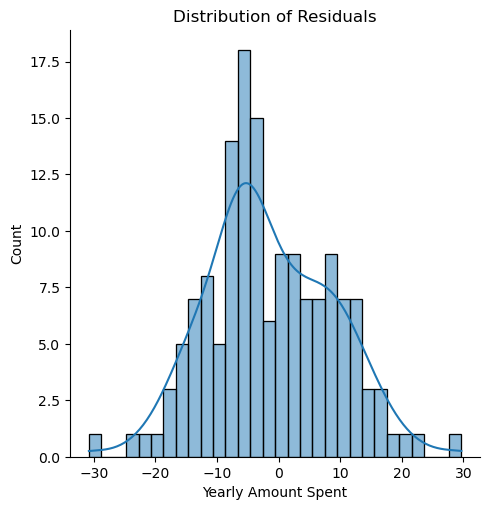

In [30]:
# Plot residuals distribution
sns.displot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")

#### Q–Q (quantile-quantile) plot. If the residuals fall along the red reference line, it suggests that they follow a normal distribution.

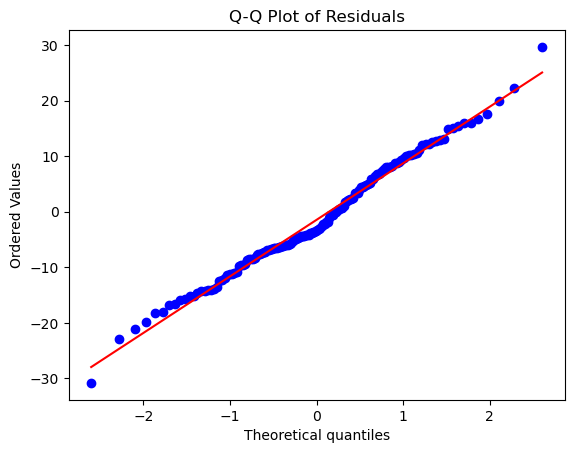

In [31]:
# Q-Q plot to check for normality
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.title("Q-Q Plot of Residuals")
pylab.show()

## Conclusion)

#### This linear regression model helped us predict annual customer spending with high accuracy. We concluded mobile app usage and length of membership are the strongest predictors of spending. In contrast, time on website is weakly correlated.